## Importação de Pacotes para Vetorização

In [2]:
#leitura da base de dados
import pandas as pd
from pathlib import Path

#pacotes para segmentar o texto e realizar a vetorização
from langchain_experimental.text_splitter import SemanticChunker
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore


c:\Users\peper\OneDrive\Documentos\PIBIC\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
direcao = Path("../..") / "data"
caminho = direcao / "df_tcu.csv"

df = pd.read_csv(caminho)

In [30]:
df["admissibilidade_concedida"] = df["admissibilidade_concedida"].replace({0: 1, 1: 0})

df_filtro = df.dropna(subset=["fundamento_legal"])

## Fazendo a Vetorização

In [4]:
corpus = df["fundamento_legal"].dropna().astype(str).tolist()

len(corpus)

1586

In [5]:
model_name = "rufimelo/bert-large-portuguese-cased-sts"

model_kwargs = {"device" : "cpu"} #pode ser alterado para "cuda" para usar processamento de placa de vídeo

encode_kwargs = {"normalize_embeddings" : False}

embeddings = HuggingFaceEmbeddings(
    model_name = model_name,
    model_kwargs = model_kwargs,
    encode_kwargs = encode_kwargs
)

vector_store = InMemoryVectorStore(embeddings)
text_splitter = SemanticChunker(embeddings, breakpoint_threshold_type="gradient")

texts = text_splitter.create_documents(corpus)
document_ids = vector_store.add_documents(documents=texts)

Invalid model-index. Not loading eval results into CardData.


In [6]:
obj_embed = embeddings.embed_documents(corpus)

In [7]:
df_embed = pd.DataFrame(obj_embed)

# Ajustando o Modelo

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import matplotlib
from sklearn.metrics import accuracy_score, f1_score, recall_score, ConfusionMatrixDisplay

In [31]:
X= df_embed
y= df_filtro["admissibilidade_concedida"]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=22)

In [32]:
logit = LogisticRegression(solver="saga", penalty="l1")

logit.fit(X_train, y_train)

logit


c:\Users\peper\OneDrive\Documentos\PIBIC\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,penalty,'l1'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'saga'
,max_iter,100
,multi_class,'deprecated'


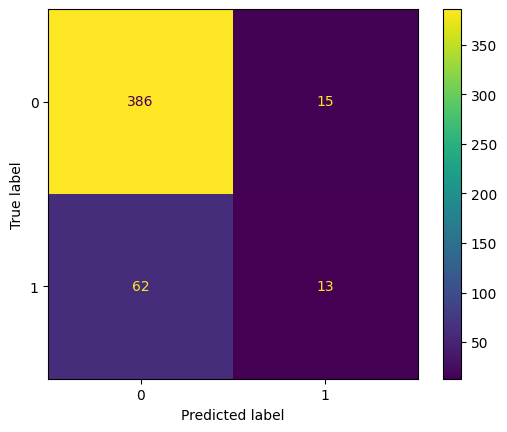

In [33]:
ConfusionMatrixDisplay.from_estimator(logit, X_test, y_test)

In [34]:
y_pred = logit.predict(X_test)

acuracia = accuracy_score(y_test, y_pred)
F1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"""
      Acurária: {round(acuracia,3)};
      F1: {round(F1,3)};
      Revocação: {round(recall,3)}
      """)


      Acurária: 0.838;
      F1: 0.252;
      Revocação: 0.173
      


## **HGS**

In [35]:
from sklearn.experimental import enable_halving_search_cv  
from sklearn.model_selection import HalvingGridSearchCV

In [ ]:
logit = LogisticRegression(solver='saga', max_iter=5000)

parametros = {
    "penalty": ["l1", "l2", "elasticnet", None],  
    "C": [0.001, 0.01, 0.1, 1, 10, 100],        
    "l1_ratio": [0, 0.25, 0.5, 0.75, 1],         
    "fit_intercept": [True, False],              
    "class_weight": [None, "balanced"]            
}

hgs = HalvingGridSearchCV(
    estimator= logit,
    param_grid= parametros,
    scoring= "roc_auc",
    cv=5,
    factor=4,         
    resource= "n_samples",
    max_resources= "auto",
    n_jobs=-1,
)

hgs.fit(X_train, y_train)

logit_HGS_CV = hgs.best_estimator_

logit_HGS_CV.fit(X_train, y_train)

c:\Users\peper\OneDrive\Documentos\PIBIC\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan na

,penalty,'l2'
,dual,False
,tol,0.0001
,C,100
,fit_intercept,False
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'saga'
,max_iter,5000
,multi_class,'deprecated'


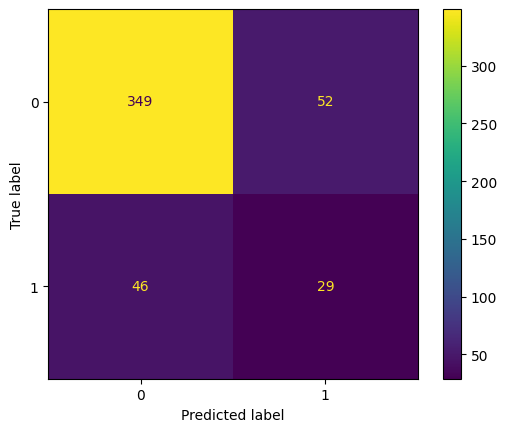

In [40]:
ConfusionMatrixDisplay.from_estimator(logit_HGS_CV, X_test, y_test)

In [41]:
y_pred = logit_HGS_CV.predict(X_test)

acuracia = accuracy_score(y_test, y_pred)
F1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"""
      Acurária_CV: {round(acuracia,3)};
      F1_CV: {round(F1,3)};
      Revocação_CV: {round(recall,3)}""")


      Acurária_CV: 0.794;
      F1_CV: 0.372;
      Revocação_CV: 0.387


# **Testando a Base com Embeddings com Floresta Aleatória**

In [42]:
from sklearn.ensemble import RandomForestClassifier

In [43]:
floresta = RandomForestClassifier()

floresta.fit(X_train, y_train)

floresta

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


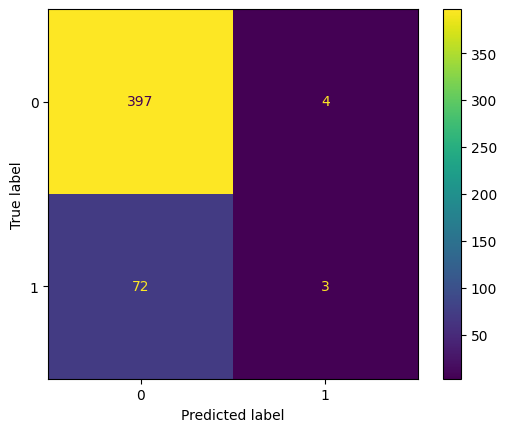

In [44]:
ConfusionMatrixDisplay.from_estimator(floresta, X_test, y_test)

In [46]:
y_pred = floresta.predict(X_test)

acuracia = accuracy_score(y_test, y_pred)
F1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"""
      Acurária: {round(acuracia,3)};
      F1: {round(F1,3)};
      Revocação: {round(recall,3)}
      """)


      Acurária: 0.84;
      F1: 0.073;
      Revocação: 0.04
      


### **HGS com Floresta Aleatória**

In [60]:
parametros = {
    "n_estimators": [100, 200, 400],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"],
    "bootstrap": [True, False],
}

hgs = HalvingGridSearchCV(
    estimator=floresta,
    param_grid=parametros,
    scoring="roc_auc",
    cv=5,
    factor=4,
    resource= "n_samples",
    max_resources= "auto",
    n_jobs=-1
)

hgs.fit(X_train, y_train)

floresta_HGS_CV = hgs.best_estimator_

floresta_HGS_CV.fit(X_train, y_train)

c:\Users\peper\OneDrive\Documentos\PIBIC\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan na

,n_estimators,100
,criterion,'gini'
,max_depth,30
,min_samples_split,2
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,False
,oob_score,False


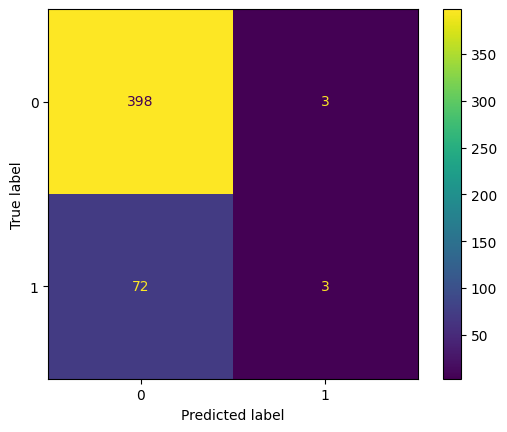

In [61]:
ConfusionMatrixDisplay.from_estimator(floresta_HGS_CV, X_test, y_test)

In [62]:
y_pred = floresta_HGS_CV.predict(X_test)

acuracia = accuracy_score(y_test, y_pred)
F1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"""
      Acurária_CV: {round(acuracia,3)};
      F1_CV: {round(F1,3)};
      Revocação_CV: {round(recall,3)}""")


      Acurária_CV: 0.842;
      F1_CV: 0.074;
      Revocação_CV: 0.04
